# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model. I also built an AdaBoosted Decision Tree model, but it performs much worse (using 5-fold cross-validation) compared with the turned random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

# Prep

## Importing Libraries and Data

In [1]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# LASSO
from sklearn.linear_model import LassoCV, Lasso

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [2]:
# Names for accessing SQL database
dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Importing Data
sql_query = """SELECT * FROM analysis_dummies_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * FROM embeddings_table;"""
embeddings = pd.read_sql_query(sql_query, con)

# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['first_skill'], axis = 1)

# Removing index col from embeddings
embeddings = embeddings.drop(['index'], axis = 1)
embeddings['profile_url'] = "https://www.guru.com" + embeddings['profile_url']

# Merging on profile_url
analysis_dt = analysis_dt.merge(embeddings, how = "left", 
                                left_on = "profile_url", right_on= "profile_url")
analysis_dt = analysis_dt.drop(['profile_url'], axis = 1)
analysis_dt = analysis_dt.fillna(0)

# Cleaning avg_word_length and bio_word count
analysis_dt.loc[analysis_dt['bio_length'] == 0, ['bio_word_count','avg_word_length']] = 0

# Removing Crazy Outliers
analysis_dt.drop(analysis_dt[analysis_dt['hourly_rate'] > 100].index, inplace = True)
analysis_dt.shape

(964, 114)

## Prepping Data for Training

In [3]:
# Converting data to numpy arrays and saving column names
y = np.array(analysis_dt['hourly_rate'])

analysis_dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(analysis_dt.columns)

X = np.array(analysis_dt)

In [4]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Defining Functions for Analysis

In [60]:
def baseline_performance(outcome_data):
    # Getting Baseline
    baseline_preds = outcome_data.mean()

    # Baseline Errors
    baseline_errors = abs(baseline_preds - outcome_data)

    # Baseline:
    print('Mean Absolute Error:', round(np.mean(baseline_errors), 2))
#     print('Mean squared error: %.2f'
#           % mean_squared_error(outcome_data, baseline_preds))
    
def model_performance(predictions, outcome_data, baseline):
    # Calculate absolute error (comparison with baseline)
    errors = abs(predictions - outcome_data)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))

    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(outcome_data, predictions))

    # The coefficient of determination (R2)
    print('Coefficient of determination: %.2f'
          % r2_score(outcome_data, predictions))

    # Does much better than the mean with regard to mean absolute error
    print("A ", round((np.mean(errors)-baseline)/baseline,3)*-100,
          "percent change over the mean")
    
def export_model(model):
    # Saving model with pickle
    filename = '/Users/Metaverse/Desktop/Insight/projects/myrate/scripts/model.sav'
    pickle.dump(model, open(filename, 'wb'))
    print("Exported")

def plot_preds_truth(x, y):
    # Calculate Error
    error = abs(x-y)
    
    # Plotting True Hourly Rates vs Predicted Hourly Rates
    sns.scatterplot(x = x, y = y, hue = error)
    sns.lineplot(x = range(0,100), y = range(0,100), palette=['red'])
    plt.ylim(0, None)
    plt.xlim(0, None)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()

# Simple Mean within Subgroups Model

In [48]:
# I need to try grouping up states. Create a facetted plot with the outcome by state and determine which ones are
# similar. Then combine?

# Modeling - LASSO

In [63]:
# Running model
model_lasso = LassoCV(cv=20).fit(X_train, y_train)
export_model(model_lasso)

Exported


In [64]:
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4
preds_lasso = model_lasso.predict(X_train)

print("Baseline Performance: ")
baseline_performance(y_train)

print("Model Performance: ")
model_performance(preds_lasso, y_train, 16.77)

Baseline Performance: 
Mean Absolute Error: 16.77
Model Performance: 
Mean Absolute Error: 16.18
Mean squared error: 424.11
Coefficient of determination: 0.05
A  3.5000000000000004 percent change over the mean


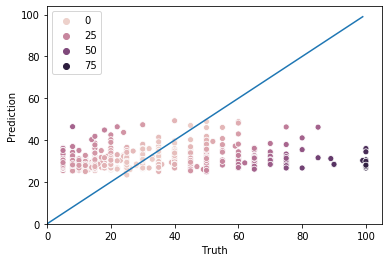

In [65]:
# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_train, y = preds_lasso)

# Modeling - Random Forest Regression
## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [68]:
# References for GridSearchCV
# 1 - https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
# 2 - https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# References for Random Forest Regression
# 1 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# 2 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Creating parameter grid
parameters = {"max_features": ["auto", "sqrt", "log2"], 
              "n_estimators": [100, 500, 900, 1300, 1500, 2000], 
              "max_depth": [None,5,10,20]}

# Creating Grid Search Class
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, verbose=True, 
                   scoring="neg_mean_absolute_error",
                   refit=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_rfr = clf.best_estimator_

# Printing results
print(round(clf.best_score_,2), clf.best_params_)

# Exporting model
export_model(model_rfr)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed: 25.5min finished


-15.71 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
Exported


## Evaluating Model

In [75]:
preds_rfr = model_rfr.predict(X_test)

print("Baseline Performance: ")
baseline_performance(y_test)

print("Model Performance: ")
model_performance(preds_rfr, y_test,16.77)

Baseline Performance: 
Mean Absolute Error: 17.23
Model Performance: 
Mean Absolute Error: 16.75
Mean squared error: 432.55
Coefficient of determination: 0.06
A  0.1 percent change over the mean


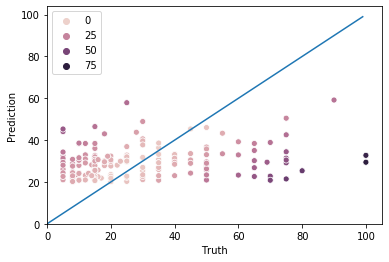

In [77]:
# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_test, y = preds_rfr)

In [50]:
# Creating parameter grid
parameters = {"n_estimators": [1, 3, 5, 10, 25, 50, 75, 100, 125, 150],
              "base_estimator__max_depth": [3, 5, 7, 9, 10, 11]}

regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(base_estimator=regr_1)

# Creating Grid Search Class
clf = GridSearchCV(regr_2, parameters, n_jobs=4, verbose=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_ada = clf.best_estimator_

# Printing results
print(round(clf.best_score_, 2), clf.best_params_)

# Exporting Model
export_model(model_ada)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 119 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:   30.1s


0.01 {'base_estimator__max_depth': 3, 'n_estimators': 3}
Exported


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.0s finished


## Evaluating Model Performance

In [66]:
print("Baseline Performance: ")
baseline_performance(y_train)

print("Model Performance: ")
model_performance(preds_ada, y_train, 16.77)

Baseline Performance: 
Mean Absolute Error: 16.77
Model Performance: 
Mean Absolute Error: 15.85
Mean squared error: 397.62
Coefficient of determination: 0.11
A  5.5 percent change over the mean


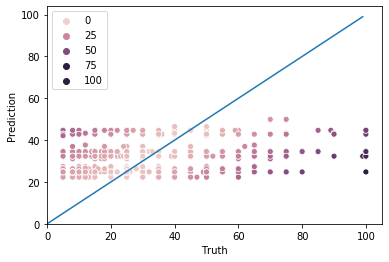

In [67]:
# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_train, y = preds_ada)